# Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Libraries**

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# **Get the GPU Support**

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# **Load IMDB Dataset**

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/FYP Datasets/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **Data Preporcessing**

## **Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le_sentiment=LabelEncoder()

In [ ]:
df["new_sentiment"]=le_sentiment.fit_transform(df["sentiment"])
df.head()

,review,sentiment,new_sentiment
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


## **90-10 Train Test Split** 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train,test=train_test_split(df,test_size=0.1)

In [ ]:
X = train.review.values
y =train.new_sentiment.values

X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.1, random_state=2020)

In [ ]:
print("Size of train dataset: ",X_train.shape)

Size of train dataset:  (40500,)


# **Prepration for BERT**

## **Install transformers**

In [ ]:
!pip install transformers

## **Data Filtering**

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()


    return text

In [ ]:
print('Original: '+"@united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?")
print('Processed: ', text_preprocessing("@united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?"))

Original: @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Processed:  I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on & check in. Can you help?


## **BERT Loading**

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

## **Finding max length of reviews to set dimensions**

In [ ]:
# Concatenate train data and test data
all_data = np.concatenate([train.review.values, test.review.values])

# Encode our concatenated data
encoded_data = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_data])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors


Max length:  3157


## **Data preprocessing**

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', len(token_ids))

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  But if you like the muppets I defy you to dislike this one. Basically the same plot regurgitated (this time New York, not LA) it features a lot of fun cameos and muppet hi-jinx. A lot of the muppets leave the film pretty early on as it centers around Kermy and Miss Piggy. I happened to have enjoyed it greatly. Fun to watch with your kids.
Token IDs:  512
Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## **Convert Data into tensors**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 10

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# **Specify BERT architecture**

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 20.3 ms, sys: 0 ns, total: 20.3 ms
Wall time: 20.3 ms


# **Attach optimizers**

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# **Training function**

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## **Training for 1 epoch**

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.624556   |     -      |     -     |   18.29  
   1    |   40    |   0.434220   |     -      |     -     |   17.70  
   1    |   60    |   0.357530   |     -      |     -     |   17.89  
   1    |   80    |   0.319742   |     -      |     -     |   18.22  
   1    |   100   |   0.388516   |     -      |     -     |   18.54  
   1    |   120   |   0.245877   |     -      |     -     |   18.75  
   1    |   140   |   0.525369   |     -      |     -     |   19.02  
   1    |   160   |   0.364363   |     -      |     -     |   19.41  
   1    |   180   |   0.326647   |     -      |     -     |   19.71  
   1    |   200   |   0.303807   |     -      |     -     |   20.03  
   1    |   220   |   0.494772   |     -      |     -     |   20.23  
   1    |   240   |   0.239261   |     -      |     -     |   20.24  


# **Function for testing**

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

# **Function to visualise predictions**

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## **AUC and Accuracy over test data**

AUC: 0.9871
Accuracy: 94.64%


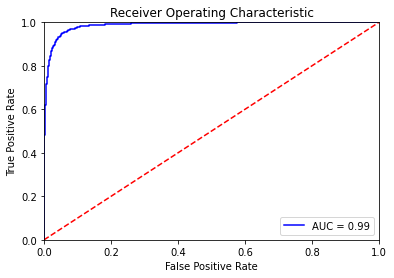

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test.review)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=10)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# **Convert probilities into 0 & 1**

## **Calculate Negitive and Non-Negitive predictions**

In [ ]:
#Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of predicted non-negative: ", preds.sum())

Number of predicted non-negative:  2498


In [ ]:
len(preds)

5000

## **Testing over Flair Dataset**

In [ ]:
predictionDataset=pd.read_csv("/content/drive/MyDrive/FYP Datasets/Flair_Sentiment_Predictions.csv")

In [ ]:
predictionDataset.head()

,address,categories,name,reviews.rating,reviews.text,emoticon,Polarity,Predicted_Sentiment,Predict_VS_Rating
0,415 Horner Avenue,"Shopping, Food, Organic Stores, Specialty Food...",Front Door Organics,5.0,"I love this service, a client had referred me ...",:),POSITIVE (0.9996),Positive,True
1,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,4.0,They have some good markdowns and prices here....,:),POSITIVE (0.9974),Positive,True
2,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,3.0,"Red, orange, yellow, green, blue, purple, pink...",:),POSITIVE (0.8543),Positive,True
3,3463 Sheppard Ave E,"Flowers & Gifts, Shopping, Florists",Helen Blakey Flowers,3.0,Got these for my birthday and they were beauti...,:),POSITIVE (1.0),Positive,True
4,2710 W Thunderbird Rd,"Shopping, Fashion, Men's Clothing, Shoe Stores",Cowtown Boots,5.0,I spent $200 on boots fore months ago here and...,:(,NEGATIVE (0.9999),Negative,False


In [ ]:
# Run `preprocessing_for_bert` on the prediction set
print('Tokenizing data...')
pre_inputs, pre_masks = preprocessing_for_bert(predictionDataset['reviews.text'])

# Create the DataLoader for our prediction set
pre_dataset = TensorDataset(pre_inputs, pre_masks)
pre_sampler = SequentialSampler(pre_dataset)
pre_dataloader = DataLoader(pre_dataset, sampler=pre_sampler, batch_size=10)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, pre_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of predicted non-negative: ", preds.sum())

Number of predicted non-negative:  315


In [ ]:
predictionDataset['BERT_ANALYSIS']=''

In [ ]:
i=0
for index,row in predictionDataset.iterrows():
  if(preds[i]==1):
    predictionDataset['BERT_ANALYSIS'][index]="Positive"
  else:
    predictionDataset['BERT_ANALYSIS'][index]="Negative"
  i=i+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
predictionDataset

,address,categories,name,reviews.rating,reviews.text,emoticon,Polarity,Predicted_Sentiment,Predict_VS_Rating,BERT_ANALYSIS
0,415 Horner Avenue,"Shopping, Food, Organic Stores, Specialty Food...",Front Door Organics,5.0,"I love this service, a client had referred me ...",:),POSITIVE (0.9996),Positive,True,Positive
1,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,4.0,They have some good markdowns and prices here....,:),POSITIVE (0.9974),Positive,True,Negative
2,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,3.0,"Red, orange, yellow, green, blue, purple, pink...",:),POSITIVE (0.8543),Positive,True,Positive
3,3463 Sheppard Ave E,"Flowers & Gifts, Shopping, Florists",Helen Blakey Flowers,3.0,Got these for my birthday and they were beauti...,:),POSITIVE (1.0),Positive,True,Positive
4,2710 W Thunderbird Rd,"Shopping, Fashion, Men's Clothing, Shoe Stores",Cowtown Boots,5.0,I spent $200 on boots fore months ago here and...,:(,NEGATIVE (0.9999),Negative,False,Negative
...,...,...,...,...,...,...,...,...,...,...
395,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,3.0,"Small, cramped and stuffy.\n\nThough the selec...",none,NEGATIVE (1.0),Negative,False,Negative
396,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,4.0,Good size store however almost everything I li...,none,NEGATIVE (0.9982),Negative,False,Negative
397,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,4.0,Great selection of polo shirts and they have g...,none,POSITIVE (1.0),Positive,True,Positive
398,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,4.0,Lacoste is one of my favorite brand started fr...,none,POSITIVE (0.9974),Positive,True,Positive


In [ ]:
count=0
for index,row in predictionDataset.iterrows():
  if row['Predicted_Sentiment']!=row['BERT_ANALYSIS']:
    count=count+1
print(count)

32


In [ ]:
predictionDataset['reviews.text'][1]

'They have some good markdowns and prices here. The downside is that they have some funky colored polos and sweaters. Neon green anyone? Upside is that they still carry the traditional white and black colors, just not as heavily discounted. I managed to snag some cool kicks and a hat for only 10 bucks! :)'

# **Saved the train model**

In [ ]:
torch.save(bert_classifier,"trained_model.pth")

In [ ]:
model=torch.load("trained_model.pth")

In [ ]:
predictionDataset.to_csv(r'/content/drive/MyDrive/FYP Datasets/BERTPytorch_VS_FLAIR.csv', index = False)